# Code Block 0

In [1]:
# Close master code repo

!git clone https://github.com/gharshit/ERA_MasterCodes.git

Cloning into 'ERA_MasterCodes'...
remote: Enumerating objects: 13, done.
remote: Counting objects: 100% (13/13), done.
remote: Compressing objects: 100% (8/8), done.
remote: Total 13 (delta 0), reused 0 (delta 0), pack-reused 0
Receiving objects: 100% (13/13), 7.70 KiB | 7.70 MiB/s, done.


# Code Block 1

In [10]:


############################ Load required libraries ############################
import torch
# !pip install torchsummary
# !pip install torch-lr-finder
from torchsummary import summary
import matplotlib.pyplot as plt


#Load required moudules
%run /content/ERA_MasterCodes/DataLoader/data_loader_A10.py
%run /content/ERA_MasterCodes/Models/models_A10.py
%run /content/ERA_MasterCodes/Train/train_A10.py
%run /content/ERA_MasterCodes/Utils/utils_A10.py




################################ Hyperparamters ################################




# variables to store data to plot accuracy and loss graphs
train_losses = []
test_losses = []
train_acc = []
test_acc = []

# Define hyperparameters
batch_size = 512               # Define the batch size for data loading
lr = 0.01                      # Define learning rate value
weightdecay = 0.0001           # Define weight decay value for L2 regularization

criterion_name = "crossentropy"     # Define criterion name
num_epochs = 24                     # Number of epochs for training
optimizer_algo = "ADAM"              # Define optimizer name
dropout_num = 0.07                   # Define dropout value

# Create a dictionary of keyword arguments (kwargs) for DataLoader
kwargs = {
    'batch_size': batch_size,   # Set the batch size for each batch of data
    'shuffle': True,            # ensures that the model encounters a diverse mix of data during training, leading to better learning and generalization (during testing, the order of data doesn’t impact the model’s predictions)
    'num_workers': 4,           # Number of worker threads for data loading ( each worker will deal with batchsize/num_workers set of data under a batch) # parallel processing-> reduces overall time
    'pin_memory': True          # Enable pinning memory for faster GPU transfer
}


<Figure size 640x480 with 0 Axes>

# Code Block 2

In [11]:
# check if CUDA is available or not
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)
device = torch.device("cuda" if cuda else "cpu")       #setting the device on which computations will be executed
print("Device set to: ",device)

CUDA Available? True
Device set to:  cuda


# Code Block 3

In [12]:
## Get CIFAR dataset and pass it to loader

_ ,test_loader            = get_CIFARdataset_with_loader('test',kwargs)   # load test data
label_, train_loader      = get_CIFARdataset_with_loader('train',kwargs)  # load train data
print()

label_map = {v: k for k, v in label_.items()}
label_map

Files already downloaded and verified
Testing data loaded successfully. Shape of data:  (10000, 32, 32, 3)
Files already downloaded and verified
Training data loaded successfully. Shape of data:  (50000, 32, 32, 3)



{0: 'airplane',
 1: 'automobile',
 2: 'bird',
 3: 'cat',
 4: 'deer',
 5: 'dog',
 6: 'frog',
 7: 'horse',
 8: 'ship',
 9: 'truck'}

# Code Block 4

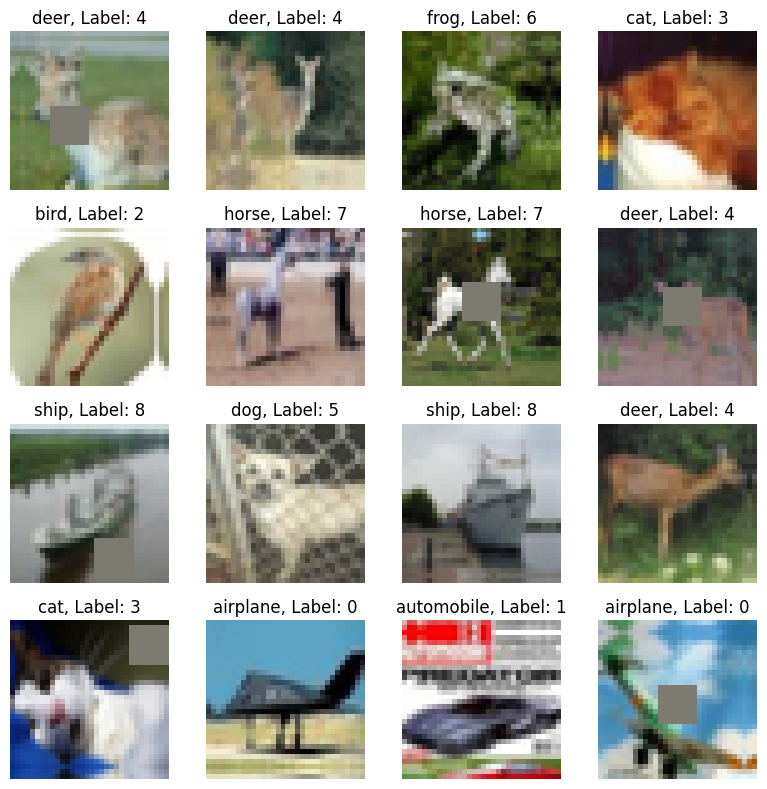

In [13]:
################ Display a sample of data from the training dataset #####################
post_display(train_loader,label_map,mean_list, std_list)

# Code Block 5

In [14]:
# For reproducibility
SEED = 4
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

# Initialize the model and move it to the device ( GPU )
model = Model_CustomResNet(dropout_value = dropout_num).to(device)

#Get summary of model
summary(model, input_size=(3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,728
       BatchNorm2d-2           [-1, 64, 32, 32]             128
              ReLU-3           [-1, 64, 32, 32]               0
           Dropout-4           [-1, 64, 32, 32]               0
            Conv2d-5          [-1, 128, 32, 32]          73,728
         MaxPool2d-6          [-1, 128, 16, 16]               0
       BatchNorm2d-7          [-1, 128, 16, 16]             256
              ReLU-8          [-1, 128, 16, 16]               0
           Dropout-9          [-1, 128, 16, 16]               0
           Conv2d-10          [-1, 128, 16, 16]         147,456
      BatchNorm2d-11          [-1, 128, 16, 16]             256
             ReLU-12          [-1, 128, 16, 16]               0
          Dropout-13          [-1, 128, 16, 16]               0
           Conv2d-14          [-1, 128,

# Code Block 6

Optimizer has been set to ADAM...
Loss evaluated through Cross Entropy...



  0%|          | 0/200 [00:00<?, ?it/s]

Stopping early, the loss has diverged
Learning rate search finished. See the graph with {finder_name}.plot()
LR suggestion: steepest gradient
Suggested LR: 1.70E-02


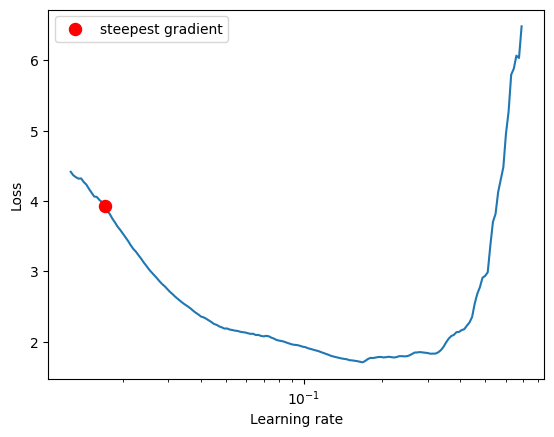

In [15]:
# Get optimizer

# Set up the optimizer as ADAM with learning rate and weight decay as 0
optimizer = get_optimizer(model,optimizer_algo, lr, weightdecay)

# Get the loss function for cross entropy
criterion = get_loss(criterion_name)

print()
# Call LR finder to get MAX_LR for OCP
lr_finder = initiateLRfinder(train_loader, model, optimizer, criterion, device)
lr_finder.reset() # to reset the model and optimizer to their initial state

# Code Block 7

In [16]:
# Set parameters for ONE CYCLE POLICY
onecyclestatus = True
max_lr   = 1.70E-02                        # Suggested LR from LR finder
steps_per_epoch = len(train_loader)        # steps per epoch == # of batches in each epoch
pct_start= 4.99/num_epochs                 # this will determine when the max_lr will be reached, we want it to reach "during" the 5th epoch
div_factor = 10                            # determines the initial learning rate via initial_lr = max_lr/div_factor
final_div_factor = 1                       # determined the minimum learning rate and we want min to be max_lr/10 only

ocp_parameters = {
    'max_lr':max_lr,
    'epochs': num_epochs,
    'steps_per_epoch':steps_per_epoch,
    'pct_start':pct_start,
    'div_factor':div_factor,
    'final_div_factor':final_div_factor
    }


# Initiate OCP
scheduler = get_scheduler(optimizer,onecycle = onecyclestatus, **ocp_parameters)

One Cycle Policy Activated...


# Code Block 8

In [17]:
#################### Start training the model ########################
lr_epoch = []

for epoch in range(1, num_epochs+1):
    # Print the current epoch number
    lr_epoch = epochLR(epoch, scheduler,lr_epoch)

    # Call the train function, passing in the model, device, data loader, scheduler, optimizer, and loss function
    train(model, device, train_loader, optimizer, criterion, scheduler, train_losses, train_acc)

    # After training, evaluate the model on the same training data loader (should be test_loader for evaluation)
    test(model, device, test_loader, criterion, test_losses, test_acc)


Current Epoch: 1 // Learning rate achieved at last epoch: [0.0017]


Train: Loss=1.3346 Batch_id=97 Accuracy=40.82: 100%|██████████| 98/98 [00:10<00:00,  9.11it/s]


Test set: Average loss: 0.0028, Accuracy: 4943/10000 (49.43%)

Current Epoch: 2 // Learning rate achieved at last epoch: [0.0032]


Train: Loss=0.9124 Batch_id=97 Accuracy=59.91: 100%|██████████| 98/98 [00:10<00:00,  9.09it/s]


Test set: Average loss: 0.0026, Accuracy: 5640/10000 (56.40%)

Current Epoch: 3 // Learning rate achieved at last epoch: [0.007]


Train: Loss=0.8523 Batch_id=97 Accuracy=68.88: 100%|██████████| 98/98 [00:10<00:00,  9.07it/s]


Test set: Average loss: 0.0027, Accuracy: 6306/10000 (63.06%)

Current Epoch: 4 // Learning rate achieved at last epoch: [0.0118]


Train: Loss=0.8375 Batch_id=97 Accuracy=72.66: 100%|██████████| 98/98 [00:10<00:00,  9.01it/s]


Test set: Average loss: 0.0014, Accuracy: 7577/10000 (75.77%)

Current Epoch: 5 // Learning rate achieved at last epoch: [0.0156]


Train: Loss=0.5966 Batch_id=97 Accuracy=76.99: 100%|██████████| 98/98 [00:10<00:00,  9.00it/s]


Test set: Average loss: 0.0016, Accuracy: 7346/10000 (73.46%)

Current Epoch: 6 // Learning rate achieved at last epoch: [0.017]


Train: Loss=0.6698 Batch_id=97 Accuracy=78.48: 100%|██████████| 98/98 [00:10<00:00,  8.96it/s]


Test set: Average loss: 0.0013, Accuracy: 7817/10000 (78.17%)

Current Epoch: 7 // Learning rate achieved at last epoch: [0.0169]


Train: Loss=0.5989 Batch_id=97 Accuracy=80.19: 100%|██████████| 98/98 [00:10<00:00,  8.95it/s]


Test set: Average loss: 0.0013, Accuracy: 7750/10000 (77.50%)

Current Epoch: 8 // Learning rate achieved at last epoch: [0.0166]


Train: Loss=0.5457 Batch_id=97 Accuracy=81.15: 100%|██████████| 98/98 [00:10<00:00,  8.98it/s]


Test set: Average loss: 0.0014, Accuracy: 7752/10000 (77.52%)

Current Epoch: 9 // Learning rate achieved at last epoch: [0.0161]


Train: Loss=0.5347 Batch_id=97 Accuracy=81.93: 100%|██████████| 98/98 [00:10<00:00,  9.00it/s]


Test set: Average loss: 0.0013, Accuracy: 7751/10000 (77.51%)

Current Epoch: 10 // Learning rate achieved at last epoch: [0.0154]


Train: Loss=0.5494 Batch_id=97 Accuracy=82.62: 100%|██████████| 98/98 [00:10<00:00,  9.04it/s]


Test set: Average loss: 0.0012, Accuracy: 8018/10000 (80.18%)

Current Epoch: 11 // Learning rate achieved at last epoch: [0.0145]


Train: Loss=0.4885 Batch_id=97 Accuracy=83.28: 100%|██████████| 98/98 [00:10<00:00,  9.04it/s]


Test set: Average loss: 0.0011, Accuracy: 8060/10000 (80.60%)

Current Epoch: 12 // Learning rate achieved at last epoch: [0.0135]


Train: Loss=0.4525 Batch_id=97 Accuracy=83.73: 100%|██████████| 98/98 [00:10<00:00,  9.01it/s]


Test set: Average loss: 0.0011, Accuracy: 8137/10000 (81.37%)

Current Epoch: 13 // Learning rate achieved at last epoch: [0.0124]


Train: Loss=0.5388 Batch_id=97 Accuracy=83.90: 100%|██████████| 98/98 [00:10<00:00,  9.01it/s]


Test set: Average loss: 0.0012, Accuracy: 7990/10000 (79.90%)

Current Epoch: 14 // Learning rate achieved at last epoch: [0.0112]


Train: Loss=0.4463 Batch_id=97 Accuracy=85.05: 100%|██████████| 98/98 [00:10<00:00,  9.02it/s]


Test set: Average loss: 0.0011, Accuracy: 8195/10000 (81.95%)

Current Epoch: 15 // Learning rate achieved at last epoch: [0.01]


Train: Loss=0.4004 Batch_id=97 Accuracy=85.88: 100%|██████████| 98/98 [00:10<00:00,  9.02it/s]


Test set: Average loss: 0.0009, Accuracy: 8528/10000 (85.28%)

Current Epoch: 16 // Learning rate achieved at last epoch: [0.0087]


Train: Loss=0.3684 Batch_id=97 Accuracy=86.90: 100%|██████████| 98/98 [00:10<00:00,  9.05it/s]


Test set: Average loss: 0.0008, Accuracy: 8591/10000 (85.91%)

Current Epoch: 17 // Learning rate achieved at last epoch: [0.0075]


Train: Loss=0.3646 Batch_id=97 Accuracy=87.51: 100%|██████████| 98/98 [00:10<00:00,  9.05it/s]


Test set: Average loss: 0.0008, Accuracy: 8611/10000 (86.11%)

Current Epoch: 18 // Learning rate achieved at last epoch: [0.0063]


Train: Loss=0.3423 Batch_id=97 Accuracy=88.58: 100%|██████████| 98/98 [00:10<00:00,  9.05it/s]


Test set: Average loss: 0.0007, Accuracy: 8716/10000 (87.16%)

Current Epoch: 19 // Learning rate achieved at last epoch: [0.0052]


Train: Loss=0.2834 Batch_id=97 Accuracy=89.65: 100%|██████████| 98/98 [00:10<00:00,  9.05it/s]


Test set: Average loss: 0.0007, Accuracy: 8836/10000 (88.36%)

Current Epoch: 20 // Learning rate achieved at last epoch: [0.0042]


Train: Loss=0.2929 Batch_id=97 Accuracy=90.58: 100%|██████████| 98/98 [00:10<00:00,  9.04it/s]


Test set: Average loss: 0.0006, Accuracy: 8950/10000 (89.50%)

Current Epoch: 21 // Learning rate achieved at last epoch: [0.0033]


Train: Loss=0.1924 Batch_id=97 Accuracy=91.49: 100%|██████████| 98/98 [00:10<00:00,  9.05it/s]


Test set: Average loss: 0.0006, Accuracy: 8982/10000 (89.82%)

Current Epoch: 22 // Learning rate achieved at last epoch: [0.0026]


Train: Loss=0.1999 Batch_id=97 Accuracy=92.32: 100%|██████████| 98/98 [00:10<00:00,  9.04it/s]


Test set: Average loss: 0.0006, Accuracy: 9092/10000 (90.92%)

Current Epoch: 23 // Learning rate achieved at last epoch: [0.0021]


Train: Loss=0.1729 Batch_id=97 Accuracy=93.25: 100%|██████████| 98/98 [00:10<00:00,  9.05it/s]


Test set: Average loss: 0.0005, Accuracy: 9146/10000 (91.46%)

Current Epoch: 24 // Learning rate achieved at last epoch: [0.0018]


Train: Loss=0.1597 Batch_id=97 Accuracy=93.88: 100%|██████████| 98/98 [00:10<00:00,  9.06it/s]


Test set: Average loss: 0.0005, Accuracy: 9105/10000 (91.05%)



# Code block 9

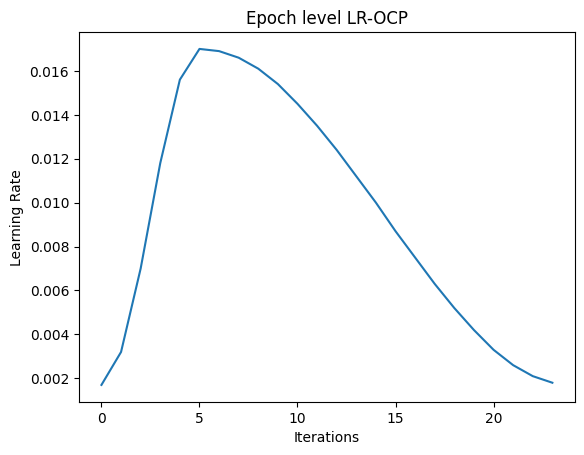

In [18]:
############# Plot LR at each epoch ##################

# Create a simple line plot
plt.plot(lr_epoch)

# Add labels and title
plt.xlabel("Iterations")
plt.ylabel("Learning Rate")
plt.title("Epoch level LR-OCP")

# Show the plot
plt.show()

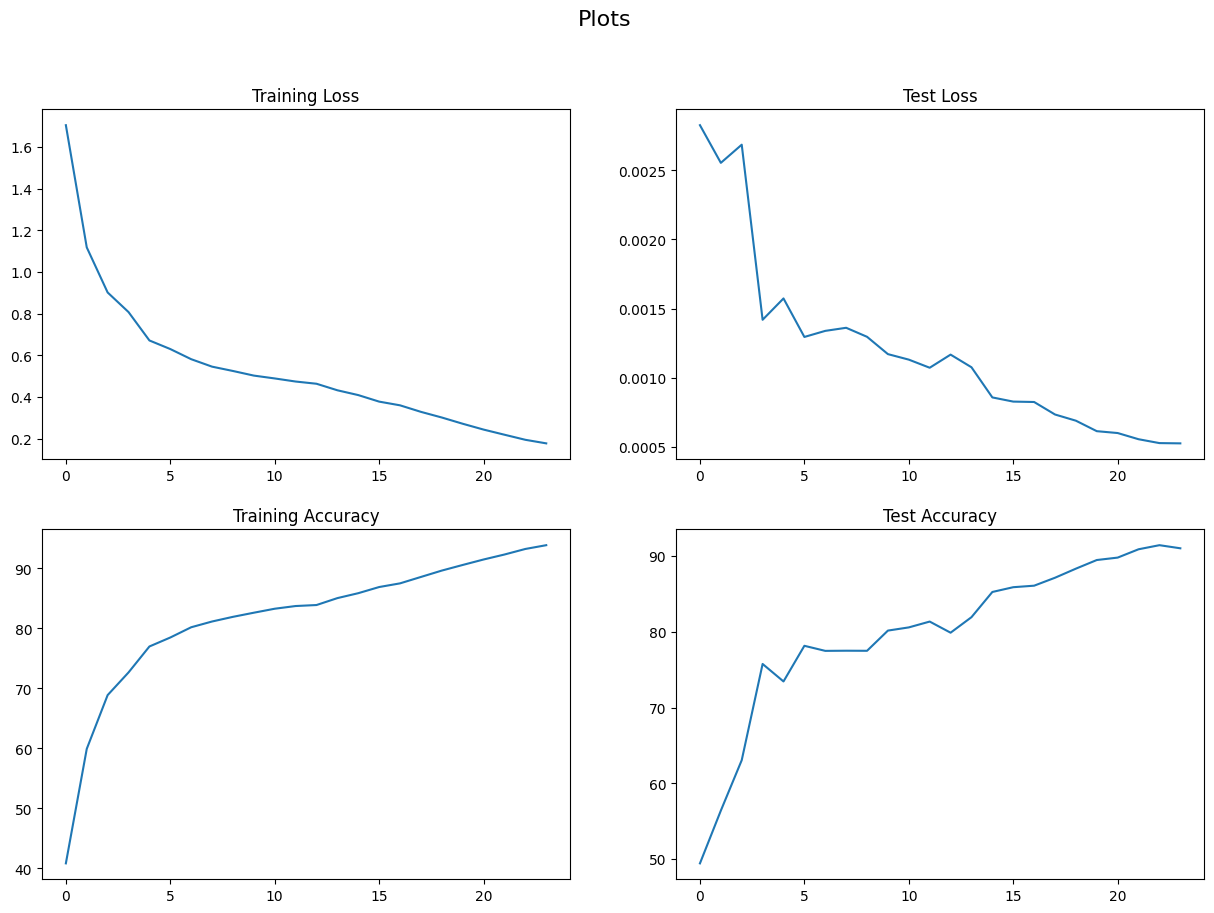

In [19]:
post_accuracyplots(train_losses,test_losses,train_acc,test_acc)